In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on


%run /afs/desy.de/user/j/jipatel/MT/MC_fit/Files_After_Acceptance/Signal_Background_thesis_final/Function.ipynb

2024-08-22 11:20:52.207538: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 11:20:52.259888: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 11:20:52.263644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 11:20:53.841567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg_ele="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/Bpeepip4Streams.root"
file_signal_ele="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/Bpeepip200000.root"


In [3]:
mc_ele_signal,mc_ele_only_signal,mc_ele_scf,mc_ele_bkg, mc_ele_signal_weight,mc_ele_only_signal_weight,mc_ele_scf_weight,mc_ele_bkg_weight = process_MC_data_combined(file_signal_ele, file_bkg_ele, 'ele', '521', 'pip', 'ee', 0, 'rec521','PIDCorrectionAndAcceptanceWeight')


In [4]:
fit_and_integrate(mc_ele_signal, param_fl_start=0.5, param_s3_start=0.01, param_p5_start=0.02, floating=True)


/tmp/ipykernel_3056446/4262147721.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cosTheta_L'] = data['cosTheta_L'].abs()
/tmp/ipykernel_3056446/4262147721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']


name                   value  (rounded)        hesse    at limit
-------------------  ------------------  -----------  ----------
extended_0.24305158             35534.9  +/- 5.3e-06       False
param_fl_0.24305158            0.530152  +/-   0.014       False
param_s3_0.24305158          -0.0421576  +/-   0.015       False
param_p5_0.24305158           -0.452438  +/-   0.033       False
Fit result valid:
True
Signal Events in MC Data = 35534.823963096664
Integrated PDF with trim: 1.0013415523441276
Integrated PDF without trim: 1.0828146963590466
Proportion of data lost: 0.0752


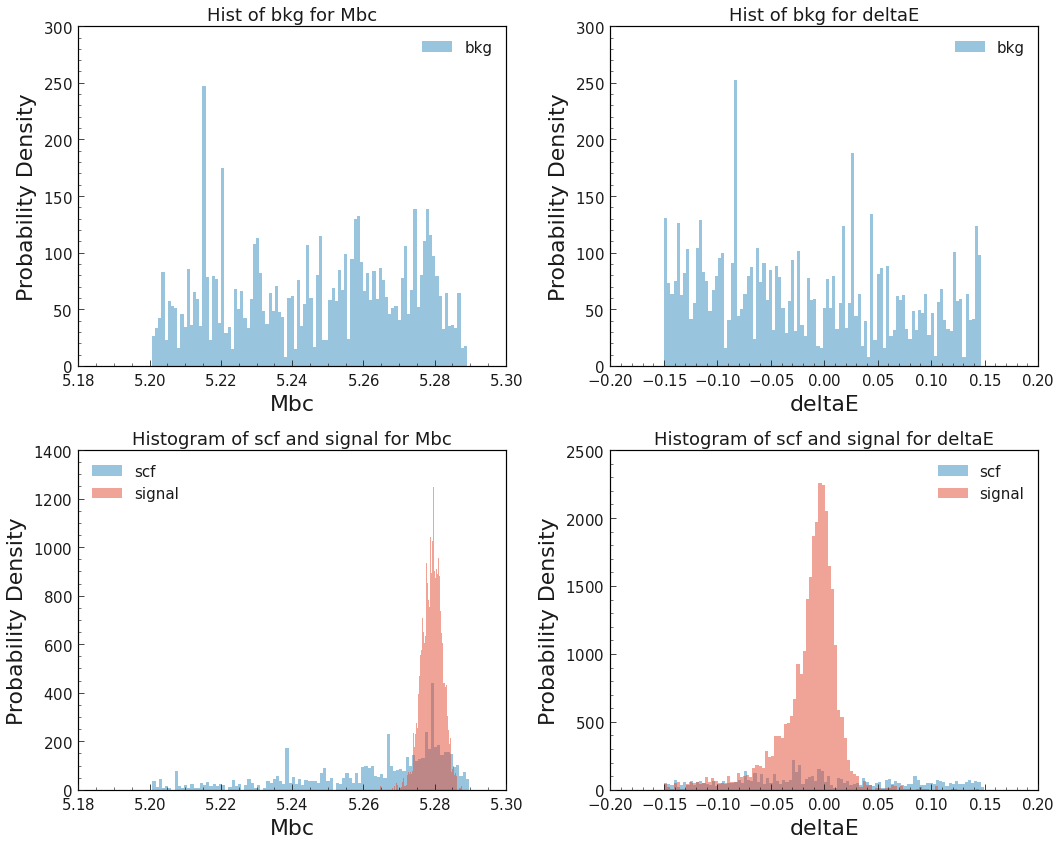

In [4]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mbc_bkg
plot_histogram(axs[0, 0], {"bkg":  mc_ele_bkg["Mbc"]},
               ["bkg"],
               {"bkg": mc_ele_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of bkg for Mbc')

# deltaE_bkg
plot_histogram(axs[0, 1], {"bkg": mc_ele_bkg["deltaE"]},
               ["bkg"],
               {"bkg": mc_ele_bkg_weight},
               'deltaE', 'Probability Density', 'Hist of bkg for deltaE')

# Mbc_signal 
plot_histogram(axs[1, 0], {"scf": mc_ele_scf["Mbc"], 
                           "signal": mc_ele_only_signal["Mbc"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight}, 
               'Mbc', 'Probability Density', 'Histogram of scf and signal for Mbc')


# deltaE_signal
plot_histogram(axs[1, 1], {"scf": mc_ele_scf["deltaE"], 
                           "signal": mc_ele_only_signal["deltaE"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight},
               'deltaE', 'Probability Density', 'Histogram of scf and signal for deltaE')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Fit ##

In [5]:
# signal
Mbc_only_signal_cb, result_Mbc_signal = fit('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss, result_deltaE_signal = fit('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)

#scf
Mbc_scf_argus_gauss, result_Mbc_scf = fit('Mbc','ele', 'scf', mc_ele_scf["Mbc"], mc_ele_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss, result_deltaE_scf = fit('deltaE','ele', 'scf', mc_ele_scf["deltaE"], mc_ele_scf_weight,'poly_gauss',0)

#bkg
Mbc_bkg_argus_gauss, result_Mbc_bkg = fit('Mbc','ele', 'bkg',  mc_ele_bkg["Mbc"], mc_ele_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss, result_deltaE_bkg = fit('deltaE','ele', 'bkg',  mc_ele_bkg["deltaE"], mc_ele_bkg_weight,'poly',0)



name                              value  (rounded)    at limit
------------------------------  ------------------  ----------
mu_ele_Mbc_signal_cb_0.4715                5.27932       False
sigma_ele_Mbc_signal_cb_0.4715          0.00269358       False
alpha_ele_Mbc_signal_cb_0.4715             1.97456       False
n_ele_Mbc_signal_cb_0.4715                 12.1202       False
True
name                                      value  (rounded)    at limit
--------------------------------------  ------------------  ----------
frac_ele_deltaE_signal_cb_gauss_0.0515            0.955849       False
mu_ele_deltaE_signal_cb_0.0515                 -0.00355318       False
sigma_ele_deltaE_signal_cb_0.0515                0.0118747       False
alpha_ele_deltaE_signal_cb_0.0515                 0.839979       False
n_ele_deltaE_signal_cb_0.0515                      2.70026       False
mu_ele_deltaE_signal_gauss_0.0515                 0.012402       False
sigma_ele_deltaE_signal_gauss_0.0515             

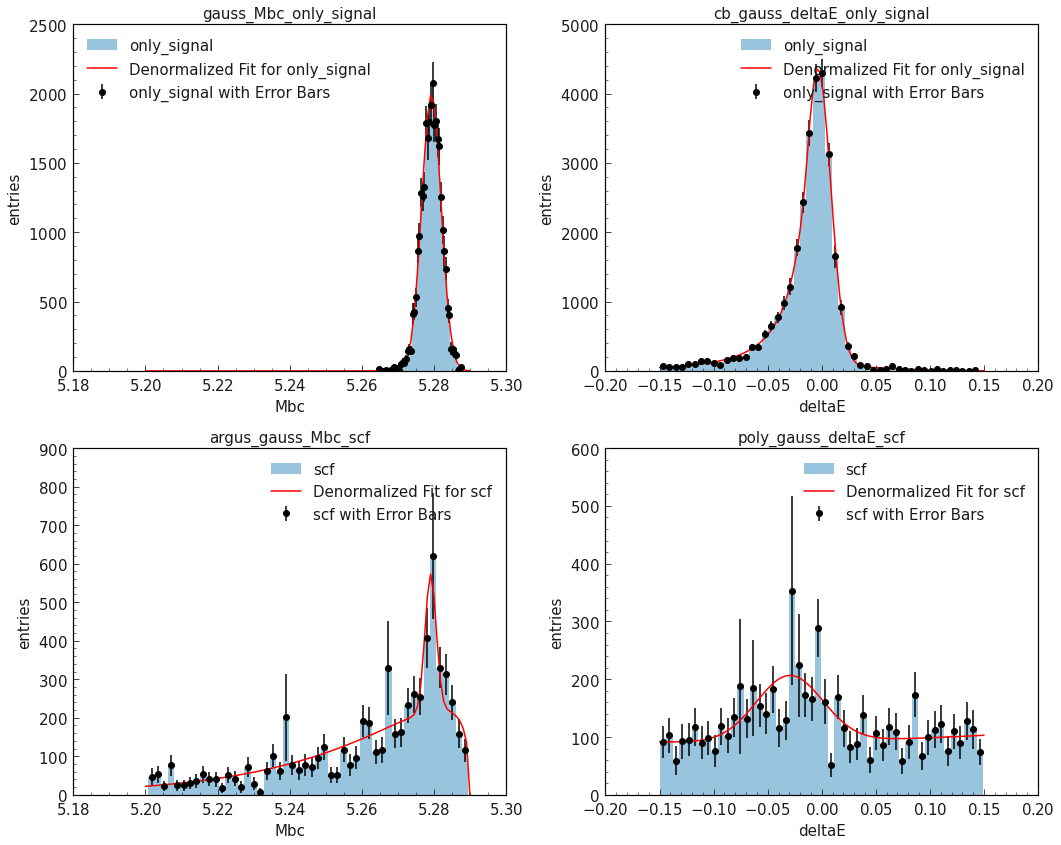

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Changed to 1 row, 2 columns

Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)

fit_model_Mbc_only_signal = plot_with_fit(axs[0,0],50, mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight, 
                                           Mbc_only_signal_cb, Mbc_range, 
                                           'only_signal', 'Denormalized Fit for only_signal', 
                                           'Mbc', 'entries', 'gauss_Mbc_only_signal')


fit_model_deltaE_only_signal = plot_with_fit(axs[0,1],50, mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight, 
                                             deltaE_only_signal_cb_gauss, deltaE_range, 
                                             'only_signal', 'Denormalized Fit for only_signal', 
                                             'deltaE', 'entries', 'cb_gauss_deltaE_only_signal')

fit_model_Mbc_scf = plot_with_fit(axs[1,0],50, mc_ele_scf["Mbc"], mc_ele_scf_weight, 
                                            Mbc_scf_argus_gauss, Mbc_range, 
                                           'scf', 'Denormalized Fit for scf', 
                                           'Mbc', 'entries', 'argus_gauss_Mbc_scf')


fit_model_deltaE_scf = plot_with_fit(axs[1,1],50, mc_ele_scf["deltaE"], mc_ele_scf_weight, 
                                             deltaE_scf_poly_gauss, deltaE_range, 
                                             'scf', 'Denormalized Fit for scf', 
                                             'deltaE', 'entries', 'poly_gauss_deltaE_scf')




# Adjust layout
plt.tight_layout()


# Print results if needed
print(result_Mbc_signal.params)
print(result_Mbc_signal.valid)
print(result_deltaE_signal.params)
print(result_deltaE_signal.valid)
print(result_Mbc_scf.params)
print(result_Mbc_scf.valid)
print(result_deltaE_scf.params)
print(result_deltaE_scf.valid)

# Show the plots
plt.show()

name                                   value  (rounded)    at limit
-----------------------------------  ------------------  ----------
frac_ele_Mbc_bkg_argus_gauss_0.7602            0.943011       False
m_ele_Mbc_bkg_argus_0.7602                      5.28918       False
c_ele_Mbc_bkg_argus_0.7602                     -35.8563       False
p_ele_Mbc_bkg_argus_0.7602                     0.428478       False
mu_ele_Mbc_bkg_gauss_0.7602                     5.27769       False
sigma_ele_Mbc_bkg_gauss_0.7602               0.00235259       False
True
name                                 value  (rounded)    at limit
---------------------------------  ------------------  ----------
coeff0_ele_deltaE_bkg_poly_0.6483           -0.319659       False
coeff1_ele_deltaE_bkg_poly_0.6483            0.107102       False
True


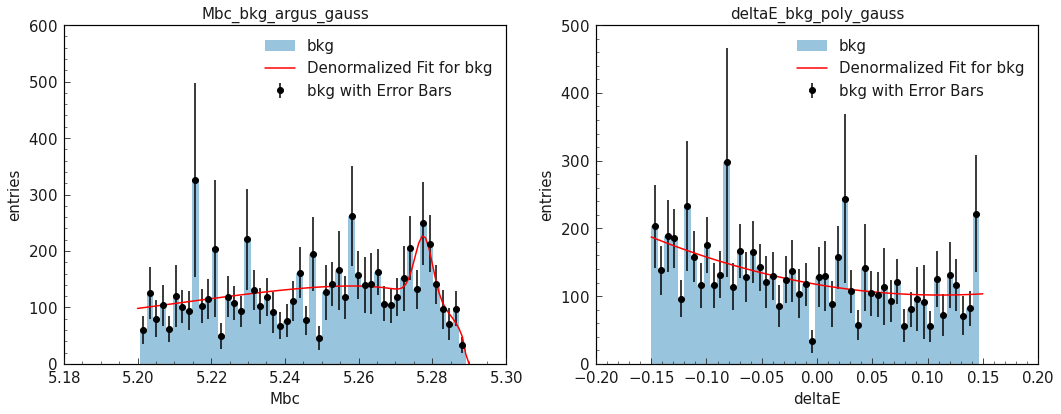

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))  # Changed to 1 row, 2 columns


Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)


fit_model_Mbc_bkg = plot_with_fit(axs[0],50, mc_ele_bkg["Mbc"], mc_ele_bkg_weight, 
                                         Mbc_bkg_argus_gauss, Mbc_range, 
                                         'bkg', 'Denormalized Fit for bkg', 
                                         'Mbc', 'entries', 'Mbc_bkg_argus_gauss')


fit_model_deltaE_bkg = plot_with_fit(axs[1],50, mc_ele_bkg["deltaE"], mc_ele_bkg_weight,
                                             deltaE_bkg_poly_gauss, deltaE_range, 
                                             'bkg', 'Denormalized Fit for bkg', 
                                             'deltaE', 'entries', 'deltaE_bkg_poly_gauss')



# Adjust layout
plt.tight_layout()

# Print results if needed
print(result_Mbc_bkg.params)
print(result_Mbc_bkg.valid)
print(result_deltaE_bkg.params)
print(result_deltaE_bkg.valid)


# Show the plots
plt.show()

## Yield

In [9]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed_unfixed_data('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed_unfixed_data('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed= fit_fixed_unfixed_data('Mbc','ele', 'scf', mc_ele_scf["Mbc"], mc_ele_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed= fit_fixed_unfixed_data('deltaE','ele', 'scf', mc_ele_scf["deltaE"], mc_ele_scf_weight,'poly_gauss',0)


#bkg
Mbc_bkg_argus_gauss_fixed= fit_fixed_unfixed_data('Mbc','ele', 'bkg',  mc_ele_bkg["Mbc"], mc_ele_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed= fit_fixed_unfixed_data('deltaE','ele', 'bkg',  mc_ele_bkg["deltaE"], mc_ele_bkg_weight,'poly',0)



In [10]:
Signal_Mbc = mc_ele_only_signal["Mbc"]
Signal_deltaE = mc_ele_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_ele_scf["Mbc"],mc_ele_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_ele_scf["deltaE"],mc_ele_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_ele_only_signal_weight
Background_weight = pd.concat([mc_ele_scf_weight,mc_ele_bkg_weight])


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model_scf(
    Mbc_only_signal_cb_fixed,Mbc_scf_argus_gauss_fixed,deltaE_only_signal_cb_gauss_fixed,deltaE_scf_poly_gauss_fixed,
    Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),1,1,10000,10000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                                     value  (rounded)               errors    at limit
-------------------------------------  ------------------  -------------------  ----------
signal_yield_0.6243                               30118.7  -1.9e+02   +1.9e+02       False
background_yield_0.6243                           11812.7  -1.4e+02   +1.3e+02       False
mu_ele_Mbc_signal_cb_0.6123                       5.27941  -1.7e-05   +1.7e-05       False
frac_ele_deltaE_signal_cb_gauss_0.725            0.946424  - 0.0036   + 0.0035       False
frac_Mbc_bkg1_0.6243                             0.354229  -   0.02   +  0.021       False
frac_ele_Mbc_scf_argus_gauss_0.85                 1.23022  -  0.031   +  0.032       False
frac_ele_Mbc_bkg_argus_gauss_0.138               0.819254  -  0.016   +  0.017       False
frac_deltaE_bkg1_0.6243                          0.608818  -   0.26   +   0.23       False
frac_ele_deltaE_scf_poly_gauss_0.2335             1.01212  -  0.021   +  0.014       False

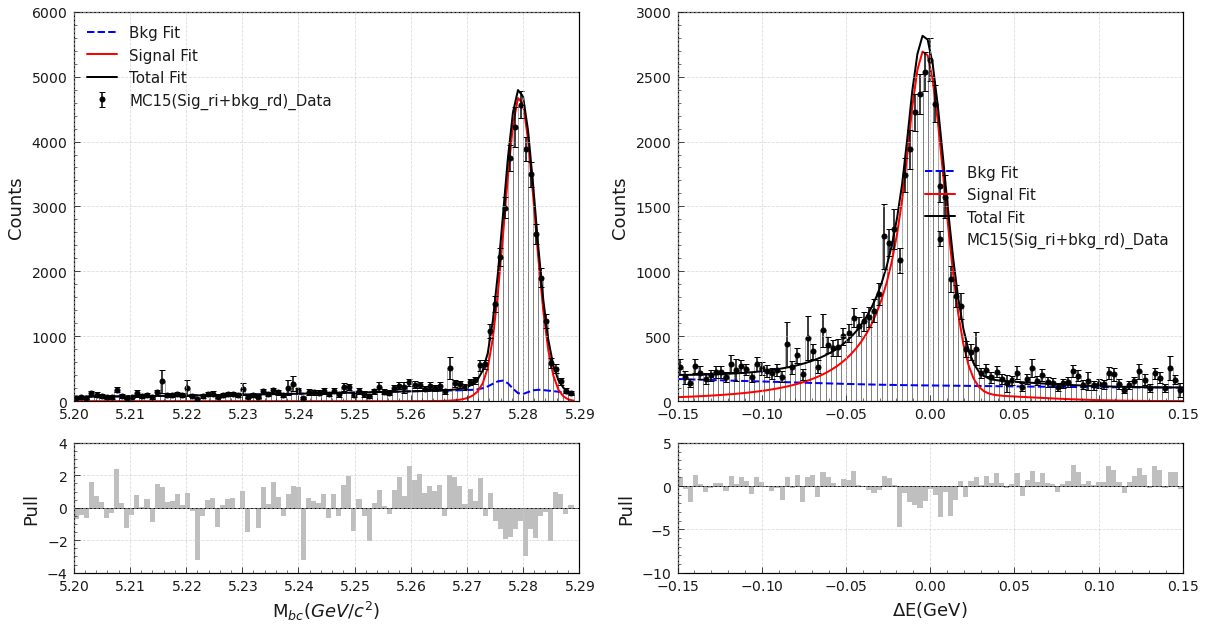

In [11]:


# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('Bppip_q2reg0_decay_ee.pdf')
plt.show()
   
